In [2]:
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split  
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Resizing, Rescaling
from keras import backend
from keras.layers import InputSpec
from keras.models import Sequential, Model
from keras.layers import Layer, InputLayer
from keras import layers
from keras.losses import MeanSquaredError
# from keras import keras_export/
# from keras.backend.common.keras_tensor import KerasTensor
import math

In [688]:
mnist, dataset_info = tfds.load('mnist', download=True, split='train',with_info = True,as_supervised=True,)
mnist

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [689]:
mnist.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [690]:
dataset_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

2024-03-31 21:59:06.041841: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


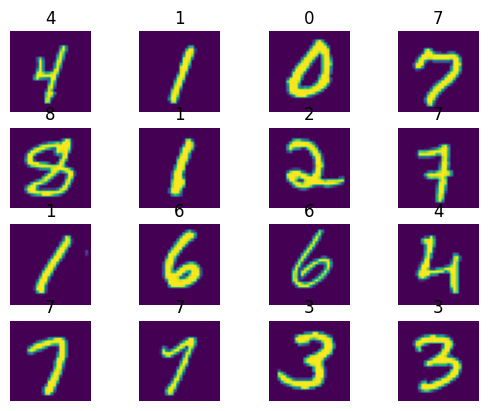

In [691]:
for i, (data) in enumerate(mnist.take(16)):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(data[0])
    plt.title(dataset_info.features["label"].int2str(np.array(data[1])))
    plt.axis('off')

In [692]:
IM_SIZE = 255.0
resize_rescale_layer = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255.0)
])

In [693]:
def train_test_split(dataset, TRAIN_SPLIT, TEST_SPLIT, VALIDATION_SPLIT):
    DATA_SIZE = len(dataset)
    
    if ((TRAIN_SPLIT + TEST_SPLIT + VALIDATION_SPLIT) <= 1):
        train_data = dataset.take(int(TRAIN_SPLIT * DATA_SIZE))
        
        remaining_data = dataset.skip(int(TRAIN_SPLIT * DATA_SIZE))
        test_data = remaining_data.take(int(TEST_SPLIT * DATA_SIZE))
        
        rem_data_for_val = remaining_data.skip(int(TEST_SPLIT * DATA_SIZE))
        val_data = rem_data_for_val.take(int(VALIDATION_SPLIT * DATA_SIZE))
        
        return train_data, test_data, val_data
    
    else:
        print("The splits are not possible due to improper ratios")
        print("The ratios must add upto 1")
        
        return None 

In [694]:
TRAIN_SPLIT = 0.8
TEST_SPLIT =  0.1
VALIDATION_SPLIT = 0.1 

training, testing, validation = train_test_split(mnist, TRAIN_SPLIT, TEST_SPLIT, VALIDATION_SPLIT)
# training = training.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
# validation = validation.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
# testing = testing.batch(1)

In [695]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

training = training.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
training = training.cache()
training = training.shuffle(dataset_info.splits['train'].num_examples)
training = training.batch(32)
training = training.prefetch(tf.data.AUTOTUNE)

In [696]:
print("Lenght of the dataset :",len(mnist))
print("Lenght of training dataset :",len(training))
print("Lenght of testing dataset :",len(testing))
print("Lenght of validation dataset :",len(validation))

Lenght of the dataset : 60000
Lenght of training dataset : 1500
Lenght of testing dataset : 6000
Lenght of validation dataset : 6000


In [697]:
sh = list(mnist.take(1).as_numpy_iterator())[0][0].shape
sh[0:]

2024-03-31 21:59:06.520415: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(28, 28, 1)

In [ ]:
(3,28,28)
28*28*

In [698]:
class CustomFlatten(Layer):
    def __init__(self, DATA_FORMAT = None):
        super(CustomFlatten, self).__init__()
        self.data_format = backend.set_image_data_format(DATA_FORMAT)
        self.data_format = backend.image_data_format()
        self.input_spec = InputSpec(min_ndim = 1)
        self.channel_fist_flag = self.data_format == "channel_first"
    
    def compute_output_shape(self, input_shape):
        non_batch_dims = input_shape[1:]
        if len(non_batch_dims) == 0:
            flatten_dims = 1
        
        elif any(d is None for d in non_batch_dims):
            flatten_dims = None
        
        else:
            flatten_dims = math.prod(non_batch_dims)
        
        return(input_shape[0], flatten_dims)
    
    def call(self, inputs):
        
        input_shape = inputs.shape
        rank = len(input_shape)
        
        if self.channel_fist_flag and rank > 1:
                inputs = tf.transpose(inputs, perm = [0,*range(1,rank),1])
        
        output_shape = tuple(
            dim if dim is not None else -1
            for dim in self.compute_output_shape(input_shape))
        
        return tf.reshape(inputs, output_shape)


# initializer was the problem, it should be zeros, cause the input seems to be zeros

In [699]:
class CustomDense(Layer):
    def __init__(self, output_units, activation ):
        super(CustomDense, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_features_shape):
        self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer="random_normal",trainable=1)
        self.b = self.add_weight(shape = (self.output_units), initializer="zeros",trainable=1)
        
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.w) + self.b
        
        if(self.activation == "relu"):
            return tf.nn.relu(pre_output)
        else:
            return pre_output

In [ ]:
class CustomLSTMCell(Layer, DropoutRNNCell):
    def __init__(self):
        super(CutomLSTMCell, self).__init__()
        pass
    
    def compute_carry_output(self, x, h_tm1, c_tm1):

In [837]:
class CustomReshape(Layer):
    def __init__(self, target_shape):
        super(CustomReshape, self).__init__()
        self.target_shape = tuple(target_shape)
        
    # def build(self, input_shape):
        
    
    def call(self, inputs):
        # self.input_shape = list(inputs.take(1).as_numpy_iterator())[0][0].shape[0]
        # print(input_shape)
        self.resolved_target_shape = tuple(-1 if d is None else d for d in self.target_shape)
        final_inputs = tf.reshape(inputs,  self.resolved_target_shape)
        return final_inputs

In [834]:
tuple([None]) + sh

(None, 28, 28, 1)

In [823]:
list(training.take(1).as_numpy_iterator())[0][0].shape[0]

32

In [777]:
class AutoEncoder(Model):
    def __init__(self, latent_dim, shape):
        super(AutoEncoder, self).__init__()
        self.shape = shape
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            CustomFlatten(DATA_FORMAT = 'channels_last'),
            CustomDense(output_units = latent_dim, activation = 'relu')
        ])
        self.decoder = tf.keras.Sequential([
            CustomDense(output_units = latent_dim, activation = 'sigmoid'),
            CustomReshape(shape)
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [773]:
shape = list(training.take(1).as_numpy_iterator())[0][0].shape
# shape[1:]
tuple(-1 if d is None else d for d in (28,28,1))

(28, 28, 1)

In [868]:
class AutoEncoder(Model):
    def __init__(self,
                image_dims,
                data_format = 'channels_last',
                latent_space = 64,
                ):
        
        super(AutoEncoder, self).__init__()
        self.input_dim = image_dims
        self.flatten_1 = CustomFlatten(DATA_FORMAT = data_format)
        self.dense_1 = CustomDense(output_units = latent_space, activation = 'relu')
        self.dense_2 = CustomDense(output_units = tf.math.reduce_prod((28, 28, 1)), activation = 'relu')
        self.final_dim = tuple([None]) + image_dims
        self.reshape = CustomReshape(target_shape = (None,28, 28, 1))
    
    def call(self, inputs):
        # self.encoder_input = layers.Input(shape = (28, 28, 1), name = 'Encoder_Input')(inputs)
        self.encoder = self.flatten_1(inputs)
        self.latent_space = self.dense_1(self.encoder)
        self.decoder_input = self.dense_2(self.latent_space)
        self.decoder_output = self.reshape(self.decoder_input)
        
        return self.decoder_output

In [869]:
model = AutoEncoder(
image_dims = list(training.take(1).as_numpy_iterator())[0][0].shape,
data_format = 'channels_last',
latent_space = 64,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    # metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], #this was the damn problem, what a headache !!
)
# model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
with tf.device('/gpu:0'):
    model.fit(training ,epochs=5,shuffle=True)

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 9.9206
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 9.1963
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 9.0004
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 8.9194
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 8.8044


In [841]:
IM_SIZE = 28
shape = list(training.take(1).as_numpy_iterator())[0][0].shape
model = tf.keras.Sequential([
    layers.Input (shape= (28, 28, 1), name = 'img'),
    CustomFlatten(DATA_FORMAT = 'channels_last'),
    CustomDense(output_units = 64, activation = 'relu'),
    CustomDense(output_units = tf.math.reduce_prod((28, 28, 1)), activation = 'relu'),
    # layers.Reshape((28, 28, 1))
    CustomReshape(target_shape = (None,28, 28, 1)) # You have to give the extra dimension of none for this to work lol
])
# model = tf.keras.Sequential([
#     # InputLayer(input_shape= (28, 28, 1)),
#     layers.Flatten(input_shape= (28, 28, 1)),
#     layers.Dense(64, activation = 'relu'),
#     layers.Dense(784, activation = 'relu'),
#     # layers.Reshape((28, 28, 1))
# ])
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])
model.summary()

Model: "sequential_186"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_flatten_104 (Custom  (None, 784)               0         
 Flatten)                                                        
                                                                 
 custom_dense_172 (CustomDe  (None, 64)                50240     
 nse)                                                            
                                                                 
 custom_dense_173 (CustomDe  (None, 784)               50960     
 nse)                                                            
                                                                 
 custom_reshape_54 (CustomR  (None, 28, 28, 1)         0         
 eshape)                                                         
                                                                 
Total params: 101200 (395.31 KB)
Trainable params: 1

In [840]:
# autoencoder.build()
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    # metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], #this was the damn problem, what a headache !!
)
# model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
with tf.device('/gpu:0'):
    model.fit(training ,epochs=5,shuffle=True)

Epoch 1/5
1500/1500 [==============================] - 5s 2ms/step - loss: 9.8575
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 8.9347
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 8.6820
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 8.5895
Epoch 5/5
1500/1500 [==============================] - 4s 2ms/step - loss: 8.5414


In [748]:
encoder_input = layers.Input(shape = (28, 28, 1), name = 'img')
x = CustomFlatten(DATA_FORMAT = 'channels_last')(encoder_input)
encoder_output = CustomDense(64, activation='relu')(x)

encoder = tf.keras.models.Model(encoder_input, encoder_output, name = 'encoder')

decoder_input = CustomDense(784, activation='relu')(encoder_output)
decoder_output = layers.Reshape((28,28,1))(decoder_input)

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
autoencoder = tf.keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 custom_flatten_73 (CustomF  (None, 784)               0         
 latten)                                                         
                                                                 
 custom_dense_110 (CustomDe  (None, 64)                50240     
 nse)                                                            
                                                                 
 custom_dense_111 (CustomDe  (None, 784)               50960     
 nse)                                                            
                                                                 
 reshape_62 (Reshape)        (None, 28, 28, 1)         0         
                                                       